In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("C:\\Users\\AK\\Downloads\\nn_train.csv")
data.head()

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023,Feature_1024,binary_label,class_label
0,1,81,109,91,96,107,97,103,95,100,...,114,93,91,98,72,92,78,78,0,5
1,2,168,168,169,169,170,171,172,172,175,...,44,44,44,44,44,44,44,44,0,9
2,3,14,20,32,6,27,6,5,34,15,...,63,64,63,60,54,48,43,41,0,5
3,4,60,109,157,126,82,80,70,58,37,...,105,102,99,98,100,105,111,114,1,8
4,5,63,72,86,75,93,77,75,67,62,...,108,109,102,106,96,91,102,89,0,5


In [3]:
X = data.iloc[:, 1:1025].values.astype(np.float32)
y = data.iloc[:, 1025].values.astype(np.float32)

In [4]:
split_length = int(0.8 * len(y))
X_train, X_dev = X[:split_length], X[split_length:]
y_train, y_dev = y[:split_length], y[split_length:]

In [5]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / (X_train_std + 1e-8)
X_dev = (X_dev - X_train_mean) / (X_train_std + 1e-8)

In [6]:
layer_sizes = [X.shape[1], 128, 64, 1]
learning_rate = 0.0001
epochs = 50
batch_size = 64
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lambda_reg = 1

In [7]:
np.random.seed(42)
parameters = {}
adam_m = {}
adam_v = {}
t = 0

In [8]:
for i in range(1, len(layer_sizes)):
    parameters[f"W{i}"] = np.random.randn(layer_sizes[i - 1], layer_sizes[i]).astype(np.float32) * np.sqrt(2 / layer_sizes[i - 1])
    parameters[f"b{i}"] = np.zeros((1, layer_sizes[i]), dtype=np.float32)
    adam_m[f"dW{i}"] = np.zeros_like(parameters[f"W{i}"])
    adam_v[f"dW{i}"] = np.zeros_like(parameters[f"W{i}"])
    adam_m[f"db{i}"] = np.zeros_like(parameters[f"b{i}"])
    adam_v[f"db{i}"] = np.zeros_like(parameters[f"b{i}"])

In [9]:
def relu(Z):
    return np.maximum(0, Z)

In [10]:
def relu_derivative(Z):
    return (Z > 0).astype(np.float32)

In [11]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [12]:
def forward_propagation(X, parameters):
    cache = {"A0": X}
    L = len(parameters) // 2
    for l in range(1, L + 1):
        Z = np.dot(cache[f"A{l-1}"], parameters[f"W{l}"]) + parameters[f"b{l}"]
        A = sigmoid(Z) if l == L else relu(Z)
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A
    return cache[f"A{L}"], cache

In [13]:
def backward_propagation(X, y, parameters, cache, lambda_reg):
    gradients = {}
    L = len(parameters) // 2
    m = X.shape[0]
    dZ = cache[f"A{L}"] - y.reshape(-1, 1)
    for l in range(L, 0, -1):
        dW = np.dot(cache[f"A{l-1}"].T, dZ) / m + (lambda_reg / m) * parameters[f"W{l}"]  
        db = np.sum(dZ, axis=0, keepdims=True) / m
        gradients[f"dW{l}"] = dW
        gradients[f"db{l}"] = db
        if l > 1:
            dA_prev = np.dot(dZ, parameters[f"W{l}"].T)
            dZ = dA_prev * relu_derivative(cache[f"Z{l-1}"])
    return gradients

In [14]:
def update_parameters_with_adam(parameters, gradients, adam_m, adam_v, t, beta1, beta2, learning_rate, epsilon):
    L = len(parameters) // 2
    t += 1
    for l in range(1, L + 1):
        adam_m[f"dW{l}"] = beta1 * adam_m[f"dW{l}"] + (1 - beta1) * gradients[f"dW{l}"]
        adam_m[f"db{l}"] = beta1 * adam_m[f"db{l}"] + (1 - beta1) * gradients[f"db{l}"]
        adam_v[f"dW{l}"] = beta2 * adam_v[f"dW{l}"] + (1 - beta2) * np.square(gradients[f"dW{l}"])
        adam_v[f"db{l}"] = beta2 * adam_v[f"db{l}"] + (1 - beta2) * np.square(gradients[f"db{l}"])
        m_dW_corrected = adam_m[f"dW{l}"] / (1 - beta1 ** t)
        m_db_corrected = adam_m[f"db{l}"] / (1 - beta1 ** t)
        v_dW_corrected = adam_v[f"dW{l}"] / (1 - beta2 ** t)
        v_db_corrected = adam_v[f"db{l}"] / (1 - beta2 ** t)
        parameters[f"W{l}"] -= learning_rate * m_dW_corrected / (np.sqrt(v_dW_corrected) + epsilon)
        parameters[f"b{l}"] -= learning_rate * m_db_corrected / (np.sqrt(v_db_corrected) + epsilon)
    return t

In [15]:
def compute_accuracy(X, y, parameters):
    A, _ = forward_propagation(X, parameters)
    predictions = (A > 0.5).astype(int)
    return np.mean(predictions.flatten() == y.flatten())

In [16]:
def compute_loss(A, y, parameters, lambda_reg):
    m = y.shape[0]
    cross_entropy_loss = -np.mean(y * np.log(A + 1e-8) + (1 - y) * np.log(1 - A + 1e-8))
    L2_loss = (lambda_reg / (2 * m)) * sum(np.sum(np.square(parameters[f"W{l}"])) for l in range(1, len(parameters) // 2 + 1))
    return cross_entropy_loss + L2_loss

In [17]:
def create_mini_batches(X, y, batch_size):
    m = X.shape[0]
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation]
    y_shuffled = y[permutation]
    mini_batches = []
    for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]
        mini_batches.append((X_batch, y_batch))
    return mini_batches

In [18]:
train_accuracies = []
dev_accuracies = []
losses = []

for epoch in range(epochs):
    mini_batches = create_mini_batches(X_train, y_train, batch_size)
    for X_batch, y_batch in mini_batches:
        A, cache = forward_propagation(X_batch, parameters)
        loss = compute_loss(A, y_batch, parameters, lambda_reg)
        gradients = backward_propagation(X_batch, y_batch, parameters, cache, lambda_reg)
        t = update_parameters_with_adam(parameters, gradients, adam_m, adam_v, t, beta1, beta2, learning_rate, epsilon)
    train_acc = compute_accuracy(X_train, y_train, parameters)
    dev_acc = compute_accuracy(X_dev, y_dev, parameters)
    train_accuracies.append(train_acc)
    dev_accuracies.append(dev_acc)
    losses.append(loss)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f} - Train Accuracy: {train_acc:.4f} - Dev Accuracy: {dev_acc:.4f}")

Epoch 1/50 - Loss: 2.4331 - Train Accuracy: 0.7381 - Dev Accuracy: 0.7239
Epoch 2/50 - Loss: 1.6363 - Train Accuracy: 0.7561 - Dev Accuracy: 0.7392
Epoch 3/50 - Loss: 1.3308 - Train Accuracy: 0.7608 - Dev Accuracy: 0.7421
Epoch 4/50 - Loss: 1.2103 - Train Accuracy: 0.7676 - Dev Accuracy: 0.7466
Epoch 5/50 - Loss: 1.0923 - Train Accuracy: 0.7768 - Dev Accuracy: 0.7559
Epoch 6/50 - Loss: 1.0661 - Train Accuracy: 0.7794 - Dev Accuracy: 0.7560
Epoch 7/50 - Loss: 1.0868 - Train Accuracy: 0.7736 - Dev Accuracy: 0.7537
Epoch 8/50 - Loss: 0.9279 - Train Accuracy: 0.7781 - Dev Accuracy: 0.7595
Epoch 9/50 - Loss: 1.0089 - Train Accuracy: 0.7894 - Dev Accuracy: 0.7612
Epoch 10/50 - Loss: 1.0947 - Train Accuracy: 0.7922 - Dev Accuracy: 0.7639
Epoch 11/50 - Loss: 1.0354 - Train Accuracy: 0.7967 - Dev Accuracy: 0.7651
Epoch 12/50 - Loss: 1.1239 - Train Accuracy: 0.7918 - Dev Accuracy: 0.7591
Epoch 13/50 - Loss: 1.0984 - Train Accuracy: 0.7977 - Dev Accuracy: 0.7649
Epoch 14/50 - Loss: 0.9591 - Train

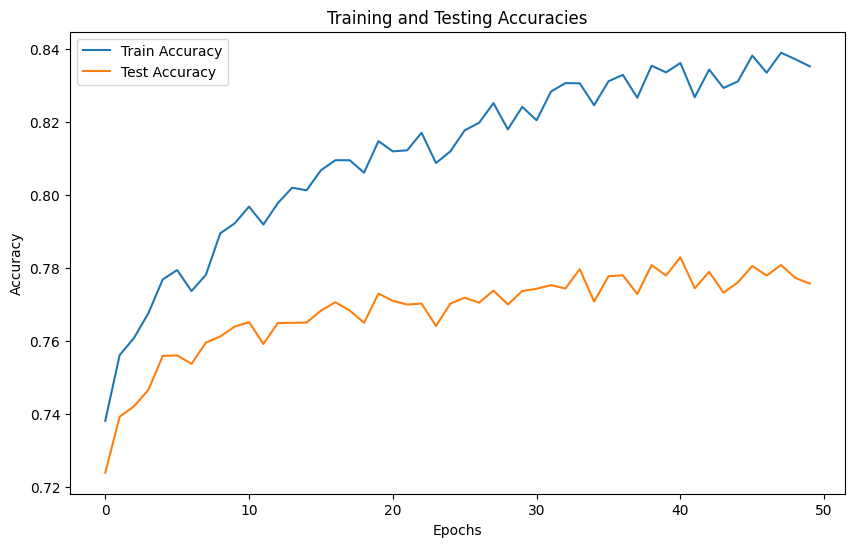

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(dev_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

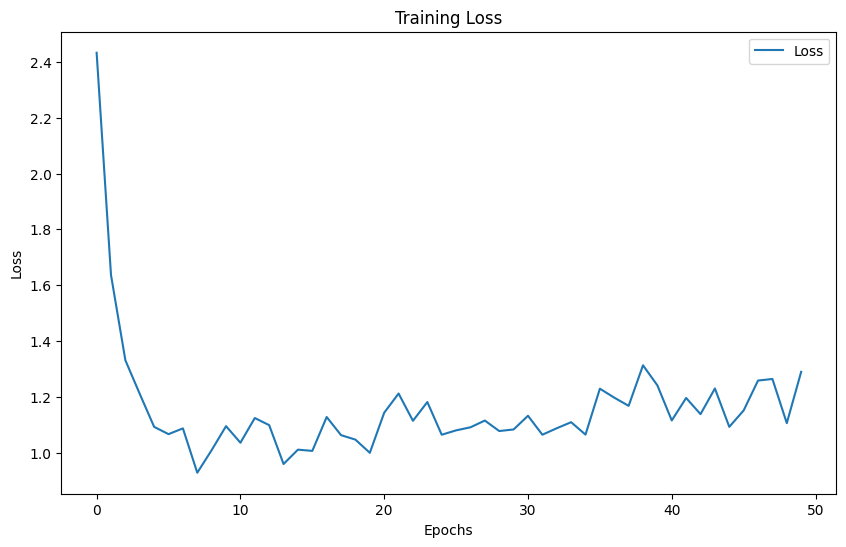

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
y_pred_train = forward_propagation(X_train, parameters)
y_pred_dev = forward_propagation(X_dev, parameters)

In [22]:
def calculate_precision(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    fp = np.sum((y_true==0) & (y_pred==1))
    return (tp / (tp+fp)) if (tp+fp) != 0 else 0

In [23]:
A_train, _ = forward_propagation(X_train, parameters)
y_pred_train = (A_train > 0.5).astype(int).flatten()

In [24]:
A_dev, _ = forward_propagation(X_dev, parameters)
y_pred_dev = (A_dev > 0.5).astype(int).flatten()

In [25]:
train_precision = calculate_precision(y_train, y_pred_train)
dev_precision = calculate_precision(y_dev, y_pred_dev)

In [26]:
print(f"The Train Precision is: {train_precision}")
print(f"The Development Precision is: {dev_precision}")

The Train Precision is: 0.8203227734608488
The Development Precision is: 0.762985855224058


In [27]:
def calculate_recall(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    return (tp / (tp+fn)) if (tp+fn) != 0 else 0

In [28]:
train_recall = calculate_recall(y_train, y_pred_train)
dev_recall = calculate_recall(y_dev, y_pred_dev)

In [29]:
print(f"The Train Recall is: {train_recall}")
print(f"The Development Recall is: {dev_recall}")

The Train Recall is: 0.8581254298755706
The Development Recall is: 0.8009732967307213


In [30]:
def calculate_f1score(precision, recall):
    return (2 * precision * recall) / (precision + recall)

In [31]:
f1score_train = calculate_f1score(train_precision, train_recall)
print(f"f1 for Training Set: {f1score_train}")

f1 for Training Set: 0.8387983986798278


In [32]:
f1score_dev = calculate_f1score(dev_precision, dev_recall)
print(f"f1 for Development Set: {f1score_dev}")

f1 for Development Set: 0.7815182321787301


In [33]:
f1score_dev

0.7815182321787301

In [36]:
test_data_actual = pd.read_csv("C:\\Users\\AK\\Downloads\\nn_test.csv")
test_data_actual.head()

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1015,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023,Feature_1024
0,1,52,36,23,15,10,14,21,20,18,...,34,65,93,81,50,81,120,80,32,30
1,2,118,119,120,121,122,123,124,125,126,...,59,56,54,54,54,53,53,52,52,52
2,3,162,166,171,175,177,179,182,184,181,...,40,39,30,30,31,33,36,40,42,43
3,4,42,38,37,42,51,57,57,55,55,...,31,28,28,26,24,23,23,21,17,14
4,5,59,131,160,129,148,173,140,118,81,...,123,122,121,118,114,112,111,109,107,105


In [38]:
X_test = test_data_actual.iloc[:, 1:].values
X_test = (X_test - X_train_mean) / (X_train_std)
A2_test, _ = forward_propagation(X_test, parameters)
y_pred_test = (A2_test > 0.5).astype(int).flatten()

In [40]:
test_data_actual['Binary Predictions'] = y_pred_test

In [41]:
test_data_actual

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023,Feature_1024,Binary Predictions
0,1,52,36,23,15,10,14,21,20,18,...,65,93,81,50,81,120,80,32,30,1
1,2,118,119,120,121,122,123,124,125,126,...,56,54,54,54,53,53,52,52,52,0
2,3,162,166,171,175,177,179,182,184,181,...,39,30,30,31,33,36,40,42,43,1
3,4,42,38,37,42,51,57,57,55,55,...,28,28,26,24,23,23,21,17,14,1
4,5,59,131,160,129,148,173,140,118,81,...,122,121,118,114,112,111,109,107,105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,25,39,38,29,29,29,31,40,40,...,76,77,69,62,59,52,40,30,25,0
19996,19997,80,179,116,8,48,86,187,179,53,...,81,48,73,72,77,78,65,64,59,0
19997,19998,255,255,254,255,255,254,255,255,255,...,67,72,68,64,62,61,61,65,70,1
19998,19999,81,95,95,94,106,111,103,98,108,...,127,130,131,131,130,129,128,130,132,0


In [43]:
test_data_actual.to_csv("Neural Network Predictions.csv")